High-performance and parallel computing for AI - Practical 4: Floating-point arithmetic and rounding error analysis
===================================================================================================================

IMPORTANT
=========

For these practicals we will be using a different `conda environment`. When opening a notebook or a terminal make sure you are using the **CuPy Kernel**!!!

Premise
=======

Goliat's hardware has limited support for reduced-precision arithmetic and the Python software support is likewise incomplete (this is a problem which we would not have if we were to use C++ or Julia on more recent hardware). Therefore, for this practical we will be using a *floating-point emulator*, which is a software tool that entirely works in double precision, but automatically rounds numbers as if computations were done in a lower-precision format. Note that **emulation is slow**: you are essentially applying a nonlinear function at every operation you perform. Bottom line: avoid crazy computations.

In particular, we will be using the `chopping` library. This is a software I wrote so:

1- Hopefully there won't be any bugs, but there might be.

2- Not all functionalities may be present.

3- I should be able to fix most issues.

**IMPORTANT:** The point of this practical is not to learn how to use the library, but simply to learn about rounding errors, reduced- and mixed-precision computations, and floating-point arithmetic.

Tutorial 1
----------

Read the following code (including the comments) and try to understand how the `chopping` library works. You can open a console if you want (remember to use the CuPy kernel) to play with the library.

First, we import numpy

In [1]:
import numpy as np

Second, we import the `chopping` library as usual

In [2]:
from chopping import *

The first thing to do when using `chopping` is to define an Option variable which defines the floating-point format we want to use and the way numbers will be rounded.

In [3]:
op = Option()
# Set floating point format. Supported formats:
# "h" for fp16, "b" for bf16, "s" for single, "d" for double.
# Can also define custom formats, but this is for another day
op.set_format("h")
# Set rounding mode. Supported modes:
# 1 - Round-to-nearest
# 2 - Round up
# 3 - Round down
# 4 - Round towards 0
# 5 - Unbiased stochastic rounding
# 6 - Biased stochastic rounding
op.set_round(1)

You can obtain info about the floating point format chosen with

In [4]:
print(op.get_floating_point_parameters())

{'t': 11, 'u': 0.00048828125, 'emax': 15, 'emin': -14, 'emins': -24, 'xmax': 65504.0, 'xmin': 6.103515625e-05, 'xmins': 5.960464477539063e-08}


The `chopping` library works via *operator overloading*. It implements a new array class, called `LPV` (it stand for "low precision variable") which looks like a very limited version of `numpy.ndarray`. This class requires an `Option` variable so that it is aware of how it should round things. When `LPV` arrays are used in arithmetic operations, the result is automatically rounded so that you do not need to worry about the rounding yourself.

An `LPV` object is defined by an underlying numpy array and an Option: 

In [5]:
# Can only wrap numpy arrays
A = np.random.randn(5,4)
Ar = LPV(A, op)

`Ar` is now an LPV variable:

In [6]:
type(Ar)

chopping.LPV

basic arithmetic operations are supported

In [7]:
C = (A + A)/2
Cr = (Ar + Ar)/2

print(type(Ar*Ar))

print("Exact:\n", C)
print("Reduced-precision:\n", Cr)

C = C@C.T
Cr = Cr@Cr.T() # for LPV arrays .T() is a function so you need to call it

print(type(Cr))

print("Exact:\n", C)
print("Reduced-precision:\n", Cr)

<class 'chopping.LPV'>
Exact:
 [[-1.09235609 -0.6587883   2.15514362  0.72898289]
 [-0.37980895 -0.76137605 -0.33892428 -0.10008303]
 [-1.80111793 -0.63093532  1.26057337 -2.17724014]
 [-0.12459186  0.32682657 -1.98867638  0.55509363]
 [-0.88334936  0.629848    0.0753798   0.97994233]]
Reduced-precision:
 LPV_array([[-1.09277344, -0.65869141,  2.15429688,  0.72900391],
           [-0.37988281, -0.76123047, -0.33886719, -0.10009766],
           [-1.80078125, -0.63085938,  1.26074219, -2.17773438],
           [-0.12457275,  0.3269043 , -1.98828125,  0.55517578],
           [-0.88330078,  0.62988281,  0.07537842,  0.97998047]])
<class 'chopping.LPV'>
Exact:
 [[ 6.80330393  0.11308294  3.5126608  -3.9604403   1.42681104]
 [ 0.11308294  0.8488346   0.95512563  0.41693843 -0.26767082]
 [ 3.5126608   0.95512563  9.971525   -3.69724641 -0.84492499]
 [-3.9604403   0.41693843 -3.69724641  4.38530142  0.70996293]
 [ 1.42681104 -0.26767082 -0.84492499  0.70996293  2.14298368]]
Reduced-precision:
 

However, **array slicing and numpy functions (including powers) are not supported**.

Nevertheless, there is a workaround: The underlying numpy array can be extracted with

In [8]:
Ar_value = Ar.array()
print("Underlying array:\n", Ar_value)

Underlying array:
 [[-1.09277344 -0.65869141  2.15429688  0.72900391]
 [-0.37988281 -0.76123047 -0.33886719 -0.10009766]
 [-1.80078125 -0.63085938  1.26074219 -2.17773438]
 [-0.12457275  0.3269043  -1.98828125  0.55517578]
 [-0.88330078  0.62988281  0.07537842  0.97998047]]


And more complicated numpy functions can be computed as follows:

In [9]:
# More complicated numpy functions are not supported, but there is a workaround:
sinCr = LPV(np.sin(Cr.array()), Cr.option)
# However, note that this means that the function is applied in double precision.

Precision and/or rounding mode mixing is NOT directly allowed:

In [10]:
op2 = Option()
op2.set_format("b")
op2.set_round(5)

Ar = LPV(A, op)
Br = LPV(A, op2)

try:
    Ar + Br
except ValueError:
    print("You shouldn't have done this!")

You shouldn't have done this!


However, you can still do it by casting one array to the other format

In [11]:
LPV(Ar.array(), op2) + Br # performs the addition in bf16.

LPV_array([[-2.171875  , -1.3125    ,  4.3125    ,  1.4609375 ],
           [-0.7578125 , -1.515625  , -0.67578125, -0.20019531],
           [-3.59375   , -1.2578125 ,  2.53125   , -4.34375   ],
           [-0.24902344,  0.65625   , -3.96875   ,  1.109375  ],
           [-1.765625  ,  1.2578125 ,  0.15039062,  1.9609375 ]])

Finally. If really needed, can do the rounding by hand without using the LPV class:

In [12]:
a = np.random.randn(10)
b = a.copy()
chop(b, op) # rounding done in-place
print(np.linalg.norm(a-b))

# chop also works with non-numpy inputs (unlike LPV) and in this case it returns a copy
a = np.pi
b = chop(a, op)
print(abs(a-b))

# If you use scalars and want to do things by hand you can simply define
c = lambda x : chop(x, op)
b = c(c(3)*c(np.pi))

0.0005413414796065511
0.000967653589793116


Practical 2 - Rounding error behaviour
--------------------------------------

** **Cancellation** **

In this excercise we will investigate the phenomenon of cancellation. Cancellation is what happens when two nearly equal numbers are subtracted and it is often, but not always, a bad thing.

Consider the quantity

$$f(x) = \frac{1-\cos(x)}{x^2}$$.

If we evaluate it in single precision at $x=3 \times 10^{-4}$ we obtain: 

In [13]:
import numpy as np
from chopping import *

op = Option()
op.set_format('s')

def f(x):
    c = LPV(np.cos(x.array()), x.option) if isinstance(x,LPV) else np.cos(x)
    return (1-c)/(x*x) # pow is not implemented so need to do x**2 by hand

y = np.array([3e-4])
x = LPV(y, op)

print("Exact:", f(y), "\nSingle precision:", f(x).array())

Exact: [0.5] 
Single precision: [0.66227376]


Note that $0\leq f(x) \leq 0.5$ for all $x$ so the single precision result is super wrong. What is happening?

Here, the exact value of $\cos(x)$ is very close to $1$, namely:

$$\cos(x) = 0.99999995500000033749999898750000162723214122991071539519074620460454744421,$$

while $1 - \cos(x)$ is given by

$$1 - \cos(x) = 4.499999966250000101249999837276785877008928460480925379539545255579 \times 10^{-8}.$$

Since $\cos(x)$ is of order $1$, rounding errors will be of order $1\times u$, which for single precision is roughly $2^{-24}=6\times 10^{-8}$. Hence, rounding errors are of the same order of $1 - \cos(x)$ and we cannot trust that our computations will approximate the numerator correctly (essentially we have almost no digits of accuracy). If we weren't dividing by $x^2$ this would not be a problem since we would notice that what we obtained is zero to within the machine precision. However, we do divide by $x^2$ which is extremely small and amplifies the error in the numerator.

This phenomenon is called *catastrophic error cancellation*. It occurs when terms which are really close to each other are subtracted and the result is fed to a routine that amplifies the resulting error.

Question 1
----------

Use the relation $\cos(x) = 1 - 2\sin^2(x/2)$ to rewrite the function $f(x)$. Re-evaluate it in single precision. The result is now correct. Why?

What happens if you evaluate the original $f(x)$ at $x=10^{-4}$? This is also the wrong answer. Can you (handwavily) explain why you obtain this value? 

(Theoretical) Let $a,b\in \mathbb{R}$ and assume we compute instead $\hat{a}=a(1+\delta_a)$, $\hat{b}=b(1+\delta_b)$, where $|\delta_a|,|\delta_b| \leq u$. Let $x = a - b$ and $\hat{x} = \hat{a} - \hat{b}$. Can you provide an upper bound to the relative (forward) error $|x - \hat{x}|/|x|$ in terms of $u$, $a$, and $b$? Assuming that this bound should be in the form $\kappa(a,b)u$ what is the value of $\kappa(a,b)$? Taking $\kappa(a,b)$ to be the *condition number* of the computation of $x$ what can you tell about the conditioning of this computation when $a$ is close to $b$ and $|a|\gg 0$?

Question 2
----------

Consider the following code:

Initial x: [100.    0.9] 
After applying the identity function: [1. 0.]


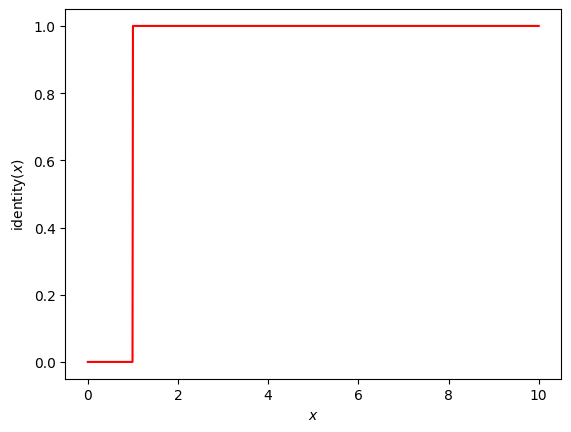

In [14]:
import numpy as np
from chopping import *
import matplotlib.pyplot as plt

op = Option()
op.set_format('s')

x = np.array([100., 0.9])

f = lambda x : LPV(np.sqrt(x.array()), op) # computing the sqrt

N = 50

def identity(x):
    x = LPV(x, op)
    for i in range(N):
        x = f(x) # takes the square root

    for i in range(N):
        x = x*x # squares the result

    return x.array()

result = identity(x)
print("Initial x:", x, "\nAfter applying the identity function:", result)

x = np.linspace(0,10,1000)
res = identity(x)
plt.xlabel('$x$')
plt.ylabel('identity$(x)$')
plt.plot(x,res, 'r-')
plt.show()

**Question:** Can you explain what is happening? Think about values of $x>1$ first and then about $x<1$. If you spend too much time on this move on to the next problem and come back to it.

Question 3
----------

Using the dot product rounding error bound that we have seen in the lectures, derive the following rounding error bound for matrix-vector products:

$$\widehat{Ab}=(A+\Delta A)b,\quad\text{where}\quad |\Delta A| \leq cnu|A|$$.

Let $\hat{x} = \widehat{Ab}$ and $x = Ab$. Use the above to derive an upper bound for the forward error $|\hat{x} - x|$ (if you are not a theoretical person you can skip this part).

Let $b$ be a Gaussian vector of length $n$ and let $A$ be a square Gaussian matrix of size $n$. For $n=2^i$ and for $i=6,\dots,11$, evaluate $x$ in half precision using the bfloat16 format and compute the resulting error in the infinity norm. Plot this error against $n$ in a loglog plot and compare it with the quantity $un\lVert x \rVert_\infty$ ($u=2^{-8}$ for bfloat16). Does the experiment match with what expected from the theory?

In [15]:
import numpy as np
from chopping import *
import matplotlib.pyplot as plt

op = Option(True)
op.set_format('b')

err = []

NN = 2**np.arange(6,12)

u = 2.**-8
bound = u*NN*abs(x).max()

## The rest is up to you. Some plotting utilities are below.

#plt.loglog(NN, err, 'r*', label='rounding error')
#plt.loglog(NN, bound, 'k--', label='upper bound')
#plt.xlabel('$n$')
#plt.ylabel('error')
#plt.legend()
#plt.show()

Question 4 - Compensated summation
----------------------------------

Let $a\in\mathbb{R}^n$ be a vector such that $a_i = \frac{2i}{n}$ for $i=1,\dots,n$. For $n=1000$ compute $s = \sum_{i=1}^n a_i$ by looping over each entry using bfloat16 half-precision. Let $\hat{s}$ be the computed bfloat16 value and compute the error $|\hat{s} - s|$ by computing the exact value of $s$.

Now, perform the half precision calculation again using the following algorithm, which is a version of **Kahan's compensated summation**: 

```python
s = 0; e = 0
for i in range(n):
    temp = s
    y = a[i] + e
    s = temp + y
    e = (temp - s) + y
```

Compute the error between this new $\hat{s}$ and $s$, i.e., $|s - \hat{s}|$. Is the error larger or smaller? Compare this error with the value of $e$. What do you observe? What do you think $e$ may mean?

Redo the exercise by varying $n$ and plotting (in loglog scale) the errors for the two algorithms for $n=2^i$ for $i=8,\dots,16$. How do the errors behave with respect to $n$ for the two algorithms?

Compute the FLOPs and memory cost of the standard VS compensated summation. Considering the FLOP and memory cost and the resulting accuracy, what are the pros and cons of using the compensated summation?

Question 5 - Floating point parameters and Overflow
---------------------------------------------------

Define an fp16 half-precision option:

```python
op = Option(True)
op.set_format('h')
```
Then call `op.get_floating_point_parameters()`. Read the [fp16 wikipedia page](https://en.wikipedia.org/wiki/Half-precision_floating-point_format#IEEE_754_half-precision_binary_floating-point_format:_binary16) and see if you understand what these parameters mean.  


Let $a\in\mathbb{R}^n$ be a vector such that $a_i = 2i$ for $i=1,\dots,n$ and consider again $s$ to be the sum of all of its entries. Assume you are computing $s$ in float16 half precision and obtain $\hat{s}$. What is the smallest value of $n$ which makes the calculation overflow? Estimate this value theoretically and demonstrate that your calculations are correct via a numerical experiment.